In [26]:
# import qiime2
import pandas as pd
import numpy as np
import torch as t
## Uncomment to get rid of warnings
#import warnings
#warnings.filterwarnings('ignore') 

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt


In [27]:
## DATA PATHS ##
fungi_decontaminated_path = 'data/count_data_fungi_decontaminated_HMS_1986samples.tsv'
fungi_high_coverage_path = 'data/count_data_fungi_high_coverage_HMS_1986samples.tsv'
fungi_WSI_intersect_path = 'data/count_data_fungi_WIS_intersect_HMS_1986samples.tsv'
fungi_metadata_path = 'data/metadata_fungi_HMS_1986samples.tsv'
tcga_abbrev_path = 'data/tcga_abbreviations.csv'

In [28]:
## DATA READS ##
fungi_decontaminated = pd.read_csv(fungi_decontaminated_path, sep='\t', header=0, index_col='sampleid')
fungi_high_coverage = pd.read_csv(fungi_high_coverage_path, sep='\t', header=0, index_col='sampleid')
fungi_WSI_intersect = pd.read_csv(fungi_WSI_intersect_path, sep='\t', header=0, index_col='sampleid')
fungi_metadata = pd.read_csv(fungi_metadata_path, sep='\t', header=0, index_col='sampleid')
tcga_abbrev = pd.read_csv(tcga_abbrev_path, index_col='dz')

In [29]:
## DATA CLEANING/PRE-PROCESSING ##
fungi_metadata_cols = ['disease_type','sample_type'] 
fungi_metadata = fungi_metadata[fungi_metadata_cols] #grab needed columns
fungi_metadata = fungi_metadata[fungi_metadata['sample_type'] == 'Primary Tumor'] #filter only Primary Tumors

min_count = 20 #drop cancers with fewer than 20 samples
fungi_metadata = fungi_metadata[fungi_metadata['disease_type'].map(fungi_metadata['disease_type'].value_counts()) > min_count]
samples = fungi_metadata.index #relevant sampleID's after final cleaning

## DATA FOR ML ##
fungi_decontaminated = fungi_decontaminated.filter(items = samples, axis=0) #filter feature tables for relevant samples
fungi_high_coverage = fungi_high_coverage.filter(items = samples, axis=0)
fungi_WSI_intersect = fungi_WSI_intersect.filter(items = samples, axis=0)
cancer_types = pd.get_dummies(fungi_metadata['disease_type']) #one hot encode disease types


In [30]:
def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = np.mean(values)
    stdev = np.std(values)
    confidence_interval = z * stdev / (len(values)**(1/2))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color=color)

    return mean, confidence_interval


def abbreviate(string):
    abbr = tcga_abbrev.loc[string][0]
    return abbr


In [31]:
#check how the validation is being performed. are there pos and neg samples in every fold?

def cross_validation(model, _X, _y, _cv=10):
    
    _scoring = ['roc_auc', 'precision', 'recall']
    
    results = cross_validate(estimator=model,
                            X=_X,
                            y=_y,
                            cv=_cv,
                            scoring=_scoring,
                            return_train_score=True)
    
    return {"Training ROC_AUC scores": results['train_roc_auc'],
          #"Mean Training ROC_AUC": results['train_roc_auc'].mean()*100,
          "Training Precision scores": results['train_precision'],
          #"Mean Training Precision": results['train_precision'].mean(),
          "Training Recall scores": results['train_recall'],
          #"Mean Training Recall": results['train_recall'].mean(),
          "Validation ROC_AUC scores": results['test_roc_auc'],
          #"Mean Validation ROC_AUC": results['test_roc_auc'].mean()*100,
          "Validation Precision scores": results['test_precision'],
          #"Mean Validation Precision": results['test_precision'].mean(),
          "Validation Recall scores": results['test_recall'],
          #"Mean Validation Recall": results['test_recall'].mean()
          }


In [32]:
## BUILD MODEL ##

#TODO: define cross validation hyperparams
n_splits = 10
skf_random = 0
shuffle=True
#TODO: define model hyperparams, can automate tuning later
n_estimators = 150
max_depth = 3
clf_random = 0 #DO NOT TOUCH

#TODO: implement model(s)
skf = StratifiedKFold(n_splits=n_splits, random_state=skf_random, shuffle=shuffle)
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=clf_random)

In [48]:
## INITIALIZE PLOT ##
fig = plt.figure(figsize=[10, 5.6])
y_ticks = plt.yticks(np.arange(11)/10)
x_ticks = plt.xticks(np.arange(1, len(cancer_types.columns)+1), [abbreviate(cancer) for cancer in cancer_types.columns])
plt.autoscale(enable = False, tight=False, axis = 'y')
title = plt.title('AUROC')

In [49]:
## AUTOMATION TIME! ##
colors = ['red','blue','orange']
offset = [-0.25, 0, 0.25]
datasets = [fungi_high_coverage, fungi_WSI_intersect, fungi_decontaminated]

for color, offset, dataset in zip(colors, offset, datasets):
    color = color
    offset = offset
    X = dataset
    
    for i, cancer in enumerate(cancer_types.columns, start=1):
        
        y = cancer_types[cancer]
        
        plt_data = np.array([])
        
        for train_index, val_index in skf.split(X, y):
            train_X, train_y = X.iloc[train_index], y.iloc[train_index]
            val_X, val_y = X.iloc[val_index], y.iloc[val_index]

            clf.fit(train_X, train_y) #fit model

            preds = clf.predict_proba(val_X)[:,1] #predict, probability of positive class predict

            score = roc_auc_score(val_y, preds) #TODO: implement separate score function to return multiple scores
            plt_data = np.append(plt_data, score)

        plot_confidence_interval(i+offset, plt_data,color=color)


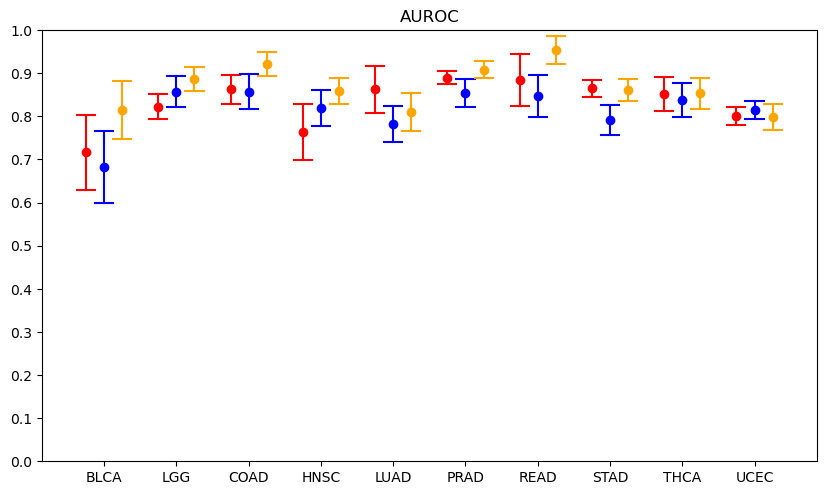

In [50]:
fig